In [35]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [36]:
df = pd.read_csv('raw_sales.csv',index_col='datesold',parse_dates=True)

In [37]:
df.sort_values(by='datesold', inplace=True)

### Visualize Daily Housing Pricess
Y-axis represented in thousands

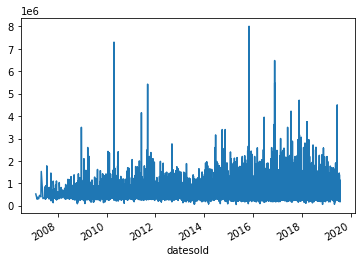

In [38]:
df['price'].plot()

In [39]:
df.reset_index(drop=False, inplace=True)
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


### Create Augmented Dickey Fuller Test for Stationarity
Create an easy to use test to determine whether the data is stationary, as this will help determine the type of forecasting model we will use.

In [40]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Monthly Aggregation

In [41]:
df['month'] = df['datesold'].values.astype('datetime64[M]')

In [42]:
monthly_df = df.groupby(['month']).agg({'price':'median', 'bedrooms':'mean'})
# monthly_df.reset_index(drop=False, inplace=True)
monthly_df.head()

,price,bedrooms
month,,
2007-02-01,407500,3.500000
2007-03-01,328000,3.333333
2007-04-01,465000,3.666667
2007-05-01,339500,3.000000
2007-06-01,451000,3.333333


In [43]:
monthly_df = monthly_df.asfreq('MS')

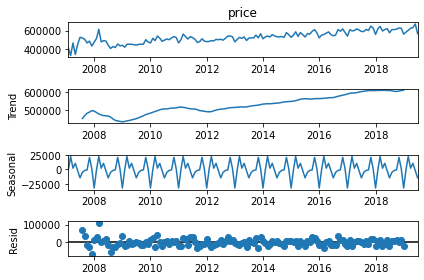

In [44]:
result = seasonal_decompose(monthly_df['price'], model='add')
result.plot();

By highlighting the seasonal component of our seasonal decomposition we can see there is some type of seasonality involved in this data

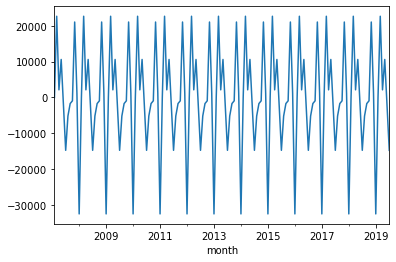

In [45]:
result.seasonal.plot()

Based on the results of our Augmented Dickey Fuller test we can see that the given the p-value is greater than 0.05, we cannot reject the null hypothesis, and should assume the data is non-stationary.

In [46]:
adf_test(monthly_df['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.242164
p-value                   0.655200
# lags used               5.000000
# observations          144.000000
critical value (1%)      -3.476598
critical value (5%)      -2.881829
critical value (10%)     -2.577589
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Compare performance of SARIMA and SARIMAX forecasting models

Based on the Akakie Information Criterion we can see that the added complexity of the Exogenous variable within the SARIMAX model was outweighed by the improvement in model fit. AIC is particularly valuable for time series, because time series analysis’ most valuable data is often the most recent, which is stuck in the validation and test sets. As a result, training on all the data and using AIC can result in improved model selection over traditional train/validation/test model selection methods.

In [47]:
auto_arima(monthly_df['price'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  150
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1758.460
Date:                            Sun, 11 Oct 2020   AIC                           3526.921
Time:                                    15:52:22   BIC                           3541.940
Sample:                                         0   HQIC                          3533.023
                                            - 150                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6058      0.065     -9.373      0.000      -0.733      -0.479
ma.L1          0.3107      0.095      3.261      0.001       0.124       0.497
ar.S.L12       0.9498      0.066     14.294      0.000       0.820       1.080
ma.S.L12      -0.8688      0.107     -8.110      0.000      -1.079      -0.659
sigma2      9.541e+08   6.25e-11   1.53e+19      0.000    9.54e+08    9.54e+08
===================================================================================
Ljung-Box (Q):                       51.64   Jarque-Bera (JB):                23.93
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+34. Standard errors may be unstable.
"""

In [48]:
auto_arima(monthly_df['price'], exogenous = monthly_df[['bedrooms']], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  150
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1729.043
Date:                            Sun, 11 Oct 2020   AIC                           3470.087
Time:                                    15:52:27   BIC                           3488.111
Sample:                                02-01-2007   HQIC                          3477.410
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3190.8230   1546.328      2.063      0.039     160.076    6221.570
bedrooms    1.476e+05   4790.953     30.801      0.000    1.38e+05    1.57e+05
ma.L1         -0.6719      0.053    -12.704      0.000      -0.776      -0.568
ar.S.L12      -0.5182      0.386     -1.344      0.179      -1.274       0.238
ma.S.L12       0.3244      0.424      0.765      0.444      -0.506       1.155
sigma2      6.818e+08      0.155    4.4e+09      0.000    6.82e+08    6.82e+08
===================================================================================
Ljung-Box (Q):                       44.28   Jarque-Bera (JB):               119.68
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.08e+24. Standard errors may be unstable.
"""

## Re-train and Test SARIMA and SARIMAX models using training / testing data sets

In [49]:
train = monthly_df[:138]
test = monthly_df[138:]

## SARIMA Model without Exogenous Variable
Reperform Auto ARIMA on training data to identify and apply the parameters used to predict on our test set

In [50]:
auto_arima(train['price'], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1621.353
Date:                              Sun, 11 Oct 2020   AIC                           3252.705
Time:                                      15:52:32   BIC                           3267.305
Sample:                                           0   HQIC                          3258.638
                                              - 138                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2449.5839   2116.737      1.157      0.247   -1699.145    6598.313
ar.L1         -0.3554      0.036     -9.797      0.000      -0.426      -0.284
ar.S.L12       0.6775      0.257      2.634      0.008       0.173       1.182
ma.S.L12      -0.5403      0.309     -1.750      0.080      -1.145       0.065
sigma2      1.164e+09      0.010    1.2e+11      0.000    1.16e+09    1.16e+09
===================================================================================
Ljung-Box (Q):                       37.52   Jarque-Bera (JB):                24.61
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.91e+26. Standard errors may be unstable.
"""

Use parameters identified above from Auto ARIMA to fit model.

Setting enfore_invertibility = True results in SARIMAX attempting to force the more recent events to have a heavier weight when compared to older data points. In some cases it may not be appropriate to weight the data points in such a way, and can result in an error. 

In [51]:
model = SARIMAX(train['price'],order=(1,1,0),seasonal_order=(1, 0, 1, 12),enforce_invertibility=False)
results = model.fit()

In [52]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
sarima_predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,0)(1,0,1,12) Predictions')

### Evaluate Model Performance of SARIMA model without Exogenous Variable

In [53]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['price'], sarima_predictions)
error2 = rmse(test['price'], sarima_predictions)

print(f'SARIMA(1,1,0)(1,0,1,12) MSE Error: {error1:11.10}')
print(f'SARIMA(1,1,0)(1,0,1,12) RMSE Error: {error2:11.10}')

SARIMA(1,1,0)(1,0,1,12) MSE Error: 799596289.4
SARIMA(1,1,0)(1,0,1,12) RMSE Error: 28277.13368


## SARIMAX Model with Exogenous Variable

In [54]:
auto_arima(train['price'], exogenous = train[['bedrooms']], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -1590.542
Date:                                 Sun, 11 Oct 2020   AIC                           3193.084
Time:                                         15:53:03   BIC                           3210.604
Sample:                                     02-01-2007   HQIC                          3200.204
                                          - 07-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms    1.384e+05   5858.389     23.619      0.000    1.27e+05     1.5e+05
ma.L1         -0.6219      0.056    -11.157      0.000      -0.731      -0.513
ar.S.L12       0.6421      0.312      2.056      0.040       0.030       1.254
ma.S.L12      -0.8934      0.327     -2.736      0.006      -1.533      -0.253
ma.S.L24       0.3614      0.090      4.007      0.000       0.185       0.538
sigma2      7.132e+08      0.101   7.07e+09      0.000    7.13e+08    7.13e+08
===================================================================================
Ljung-Box (Q):                       38.00   Jarque-Bera (JB):                87.99
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.57e+25. Standard errors may be unstable.
"""

In [55]:
model = SARIMAX(train['price'],exog=train['bedrooms'],order=(0,1,1),seasonal_order=(1, 0, [1,2], 12),enforce_invertibility=False)
results = model.fit()

In [56]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['bedrooms']]  
sarimax_predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(0,1,1)(1,0,[1,2],12) Predictions')

### Evaluate Model Performance

In [57]:
# Print values from SARIMA above
print(f'SARIMA(1,1,0)(1,0,1,12) MSE Error: {error1:11.10}')
print(f'SARIMA(1,1,0)(1,0,1,12) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['price'], sarimax_predictions)
error2x = rmse(test['price'], sarimax_predictions)

# Print new SARIMAX values
print(f'SARIMAX(0,1,1)(1,0,[1,2],12) MSE Error: {error1x:11.10}')
print(f'SARIMAX(0,1,1)(1,0,[1,2],12) RMSE Error: {error2x:11.10}')

SARIMA(1,1,0)(1,0,1,12) MSE Error: 799596289.4
SARIMA(1,1,0)(1,0,1,12) RMSE Error: 28277.13368

SARIMAX(0,1,1)(1,0,[1,2],12) MSE Error: 248300696.2
SARIMAX(0,1,1)(1,0,[1,2],12) RMSE Error: 15757.55997


## Plot Predictions Against Known Values

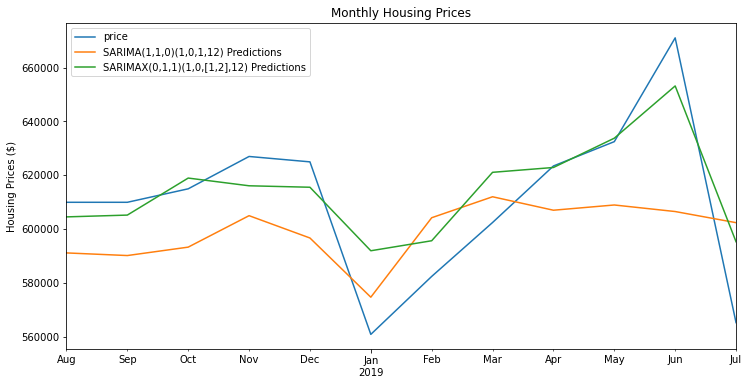

In [58]:
title='Monthly Housing Prices'
ylabel='Housing Prices ($)'
xlabel=''

ax = test['price'].plot(legend=True,figsize=(12,6),title=title)
sarima_predictions.plot(legend=True)
sarimax_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Conclusion
Based on both our error measurements and by analyzing our plotted comparison of actauls vs SARIMA and SARIMAX models we can see that having knowledge of the average monthly # of bedrooms per house sold improves our ablity to forecast median housing values.